In [2]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12d_cgan.ipynb"
_nb_title = "조건부 GAN"
_nb_message = """
MNIST에 대해 바닐라 및 심층 컨볼루션 조건부 GAN을 훈련.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EC%A1%B0%EA%B1%B4%EB%B6%80+GAN&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F12_generation%2F12d_cgan.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>조건부 GAN</h1>
MNIST에 대해 바닐라 및 심층 컨볼루션 조건부 GAN을 훈련.


# 조건부 생성적 적대 네트워크(cGANs: Conditional Generative Adversarial Networks)

## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


In [2]:
# 라이브러리 및 모듈 임포트
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.21.6


## 상수

In [3]:
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
LATENT_DIM = 512

## 바닐라 GAN

바닐라 GAN에서는 생성기와 판별기에 기본 `Dense` 레이어를 사용

In [4]:
# 생성기를 만듦.
def create_label_vectors(
    labels, num_classes, embedding_dim, dense_units
):
    """라벨 인덱스들로부터 라벨 벡터를 만듦.

    Args:
        labels: tensor, 모양이 (batch_size,)인 라벨의 1계 텐서서.
        num_classes: int, 이미지 클래스의 수.
        embedding_dim: int, 임베딩의 출력 차원.
        dense_units: int, `Dense` 레이어의 유닛 수.

    Returns:
        label_vectors: tensor, 모양이 (batch_size, dense_units)인 2계 텐서.
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    label_vectors = tf.keras.layers.Dense(
        units=dense_units
    )(inputs=embedded_labels)

    return label_vectors

def standard_vanilla_generator(inputs, output_shape):
    """표준 바닐라 생성기 레이어의 출력을 반환.

    Args:
        inputs: tensor, 모양이 (batch_size, y, x, channels)인 4계 텐서.
        output_shape: tuple, 배치 차원이 없는 출력의 모양.

    Returns:
        outputs: tensor, 모양이 (batch_size, height, width, depth)인 4계 텐서.
    """
    x = tf.keras.layers.Dense(units=64)(inputs=inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(
        units=output_shape[0] * output_shape[1] * output_shape[2],
        activation="tanh"
    )(inputs=x)

    outputs = tf.keras.layers.Reshape(target_shape=output_shape)(inputs=x)

    return outputs

def create_vanilla_generator(latent_dim, num_classes, output_shape):
    """바닐라 조건부 GAN 생성기 모델을 만듦.

    Args:
        latent_dim: int, 잠재 벡터 차원 길이.
        num_classes: int, 이미지 클래스 수.
        output_shape: tuple, 배치 차원이 없는 출력의 모양.

    Returns:
        Keras 함수형 모델.
    """
    latent_vector = tf.keras.Input(shape=(latent_dim,))

    labels = tf.keras.Input(shape=())
    label_vectors = create_label_vectors(
        labels, num_classes, embedding_dim=50, dense_units=50
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_vector, label_vectors])
    
    outputs = standard_vanilla_generator(
        inputs=concatenated_inputs, output_shape=output_shape
    )

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="vanilla_generator"
    )

vanilla_generator = create_vanilla_generator(
    latent_dim=LATENT_DIM, num_classes=NUM_CLASSES, output_shape=IMAGE_SHAPE
)
vanilla_generator.summary()

Model: "vanilla_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50)           500         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 50)           2550        ['embedding[0][0]']              
                                                                                  

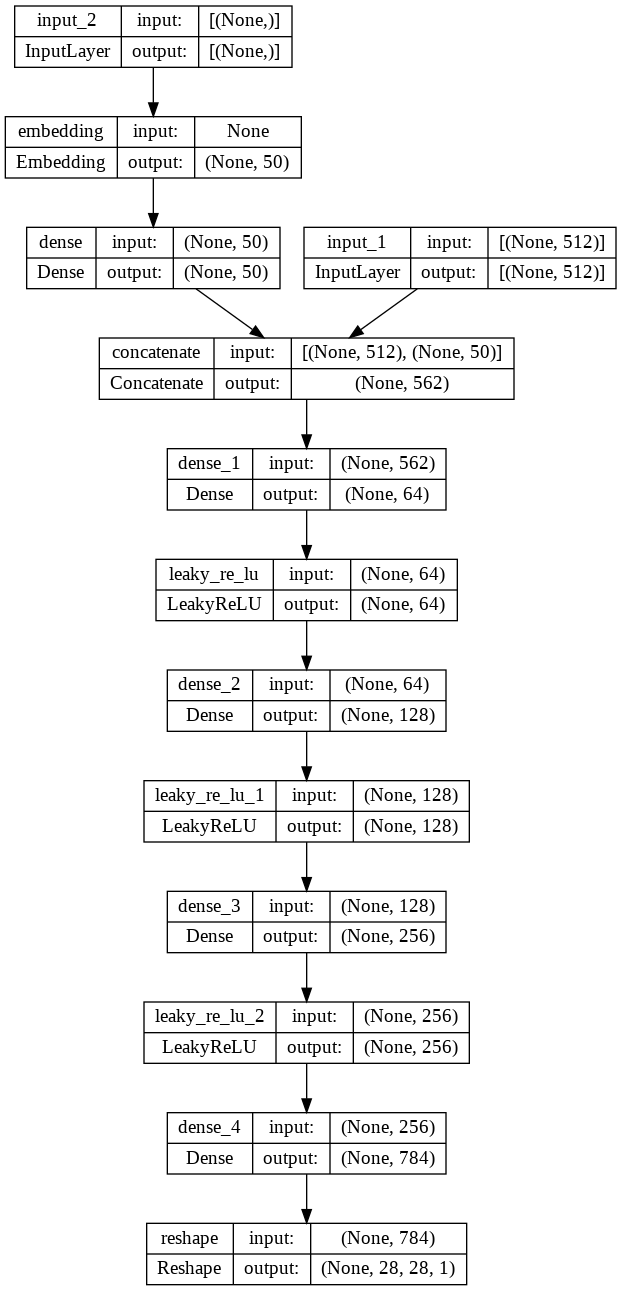

In [5]:
# 생성기 모델을 플롯.
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="conditional_vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [6]:
# 판별기를 만듦.
def create_label_images(
    labels, num_classes, embedding_dim, image_shape
):
    """라벨 인덱스로부터 라벨 이미지를 만듦.

    Args:
        labels: tensor, 모양이 (batch_size,)인 라벨들의 1계 텐서.
        num_classes: int, 이미지 클래스 수.
        embedding_dim: int, 임베딩의 출력 차원.
        image_shape: tuple, 배치 차원이 없는 이미지의 모양.

    Returns:
        label_image: tensor, 모양이 (batch_size, height, width, 1)인 4계 텐서.
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    num_pixels = image_shape[0] * image_shape[1]
    dense_labels = tf.keras.layers.Dense(
        units=num_pixels
    )(inputs=embedded_labels)
    label_image = tf.keras.layers.Reshape(
        target_shape=(image_shape[0], image_shape[1], 1)
    )(inputs=dense_labels)

    return label_image

def standard_vanilla_discriminator(inputs):
    """표준 바닐라 판별기 레이어들의 출력을 반환.

    Args:
        inputs: tensor, 모양이 (batch_size, y, x, channels)인 4계 텐서.

    Returns:
        outputs: tensor, 모양이 (batch_size, height, width, depth)인 4계 텐서.
    """
    x = tf.keras.layers.Flatten()(inputs=inputs)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=64)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)

    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_vanilla_discriminator(image_shape, num_classes):
    """바닐라 조건부 GAN 판별기 모델을 만듦.

    Args:
        image_shape: tuple, 배치 차원이 없는 이미지의 모양.
        num_classes: int, 이미지 클래스들의 수.

    Returns:
        Keras 함수형 모델.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels, num_classes, embedding_dim=50, image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_vanilla_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="vanilla_discriminator"
    )

vanilla_discriminator = create_vanilla_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50)           500         ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 784)          39984       ['embedding_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                              

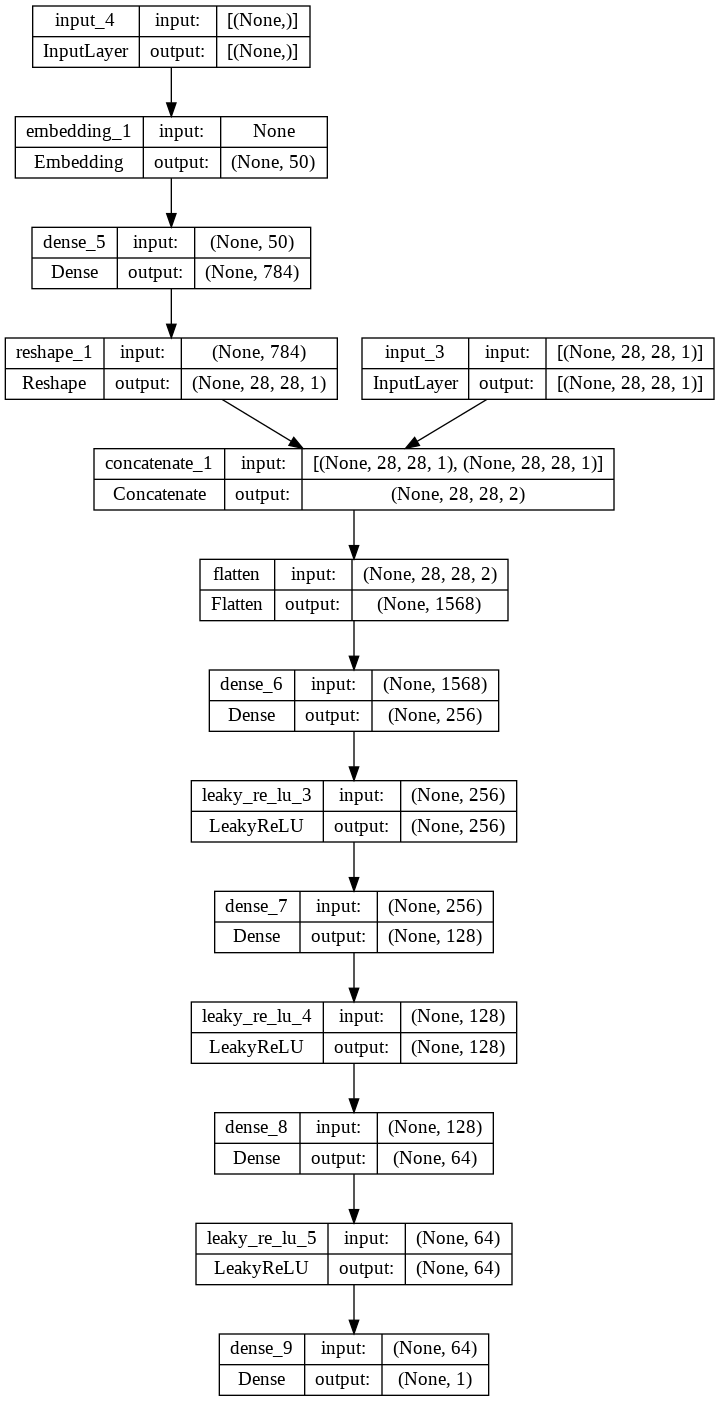

In [7]:
# 판별기 모델을 플롯.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="conditional_vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

생성기 및 판별기 네트워크의 훈련을을 용이하게 하는 데 사용할 수 있는 `GAN`이라는 커스텀 `Model` 클래스를 만든다.

In [8]:
class GAN(tf.keras.Model):
    """GAN을 훈련하는 커스텀 모델.

    Attributes:
        discriminator: Keras `Model`, 판별기 네트워크.
        generator: Keras `Model`, 생성기 네트워크.
        latent_dim: int, 잠재 벡터 차원 길이.
        one_sided_label_smoothing: float, [0., 1.]의 값으로 실제 이미지 레이블을 얼마나 매끄럽게 할 것인지.
        discriminator_optimizer: Keras `Optimizer`, 판별기 네트워크의 옵티마이저.
        generator_optimizer: Keras `Optimizer`, 생성기 네트워크의 옵티마이저.
        loss_fn: Keras `Loss`, 두 네트워크를 훈련하기 위한 손실 함수.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """`GAN` 모델 클래스를 인스턴스화.

        Args:
            discriminator: Keras `Model`, 판별기 네트워크.
            generator: Keras `Model`, 생성기 네트워크.
            latent_dim: int, 잠재 벡터 차원 길이.
            one_sided_label_smoothing: float, [0., 1.]의 값으로 실제 이미지 레이블을 얼마나 매끄럽게 할 것인지.
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """기본 `Model` 클래스의 compile 메서드를 재정의.

        Args:
            discriminator_optimizer: Keras `Optimizer`, 판별기 네트워크의 옵티마이저.
            generator_optimizer: Keras `Optimizer`, 생성기 네트워크의 옵티마이저.
            loss_fn: Keras `Loss`, 두 네트워크를 훈련하기 위한 손실 함수.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images, input_labels):
        """판별기를 한 스텝 훈련.

        Args:
            batch_size: tensor, 미니 배치의 요소 수를 나타내는 스칼라 텐서.
            real_images: tensor, 모양이 (batch_size, height, width, depth)인 실제 이미지들의 4계 텐서.
            input_labels: tensor, 모양이 (batch_size,)인 라벨들의 1계 텐서.

        Returns:
            discriminator_loss: tensor, 판별기 스텝의 스칼라 손실.
        """
        # 잠재 공간에서 임의의 지점을 샘플링.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 노이즈로부터 이미지들을 생성.
        generated_images = self.generator(
            inputs=[random_latent_vectors, input_labels]
        )

        # 생성된 이미지와 실제 이미지를 조합.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # 가짜 라벨과 진짜 라벨을 생성.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # 훈련으로 진짜 라벨들을 평탄화.
        real_labels *= self.one_sided_label_smoothing

        # 조합한 이미지들과 인라인 되도록 라벨들을 조합.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # 판별기만 훈련.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=[
                    combined_images,
                    tf.concat(values=[input_labels, input_labels], axis=0)
                ]
            )
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size, input_labels):
        """생성기를 한 스텝 훈련.

        Args:
            batch_size: tensor, 미니 배치의 요소 수를 나타내는 스칼라 텐서.
            input_labels: tensor, 모양이 (batch_size,)인 라벨들의 1계 텐서.

        Returns:
            generator_loss: tensor, 생성기 스텝의 스칼라 손실.
        """
        # 잠재 공간에서 무작위 포인트를 샘플링.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 실제 이미지인 것처럼 레이블을 만듦.
        labels = tf.ones(shape=(batch_size, 1))

        # 생성기만 훈련.
        with tf.GradientTape() as tape:
            fake_images = self.generator(
                inputs=[random_latent_vectors, input_labels]
            )
            predictions = self.discriminator(
                inputs=[fake_images, input_labels]
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, features):
        """`GAN`을 한 스텝 훈련.

        Args:
            features: dict, 이미지 키에는 값에 대해 (batch_size, height, width, depth)
            모양이 있는 실제 이미지의 4계 텐서가 있고, 라벨 키에는 (batch_size,) 모양이
            있는 라벨의 1계 텐서가 있음.

        Returns:
            losses: dict, 각 하위 훈련 단계의 손실 딕셔너리.
        """
        real_images = features["images"]
        input_labels = features["labels"]

        # 랜덤 노이즈 벡터에 사용할 동적 배치 크기를 가져옴옴.
        batch_size = tf.shape(input=real_images)[0]

        # 먼저 판별기를 훈련.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images, input_labels
        )

        # 다음으로 생성기를 훈련.
        generator_loss = self.generator_train_step(
            batch_size, input_labels
        )

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [9]:
def create_train_dataset(batch_size):
    """훈련 데이터셋을 생성.

    Args:
        batch_size: int, 미니 배치에 있는 요소의의 수.

    Returns:
        dataset: `Dataset`, MNIST를 사용해 훈련하기 위한 데이터셋 객체.
    """
    # MNIST 데이터 로딩.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # 훈련 및 테스트 셋을 조합.
    combined_images = np.concatenate([x_train, x_test])
    combined_images = (combined_images.astype("float32") - 127.5) / 255.0
    combined_images = np.reshape(combined_images, newshape=(-1, 28, 28, 1))

    combined_labels = np.concatenate([y_train, y_test])

    # 훈련을 위해 tf.data.Dataset을 생성.
    dataset = tf.data.Dataset.from_tensor_slices(
        tensors={"images": combined_images, "labels": combined_labels}
    )
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset


In [10]:
# 바닐라 생성기와 판별기를 사용해 GAN 인스턴스를 인스턴스화.
vanilla_gan = GAN(
    discriminator=vanilla_discriminator,
    generator=vanilla_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9
)

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# 바닐라 GAN 모델을 훈련.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128), epochs=30
)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 7s 6ms/step - discriminator_loss: 0.5758 - generator_loss: 1.6211
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - discriminator_loss: 0.5252 - generator_loss: 1.6698
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - discriminator_loss: 0.5536 - generator_loss: 1.4543
Epoch 4/30
547/547 [==============================] - 4s 6ms/step - discriminator_loss: 0.5757 - generator_loss: 1.4003
Epoch 5/30
547/547 [==============================] - 4s 6ms/step - discriminator_loss: 0.5971 - generator_loss: 1.3650
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - discriminator_loss: 0.5956 - generator_loss: 1.3528
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - discriminator_loss: 0.5929 - generator_loss: 1.3427
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - discriminator_loss: 0.5988 

학습된 모델을 사용하여 손실 히스토리와 일부 생성된 이미지를 플로팅해 보자.

In [11]:
def plot_loss_history(history):
    """손실 히스토리를 플롯.

    Args:
        history: `keras.callbacks.History`, 훈련 작업의 히스토리 객체.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [12]:
def plot_images(images):
    """이미지를 플롯.

    Args:
        images: np.array, [num_images, image_size, image_size, num_channels]의
            이미지의 배열.
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

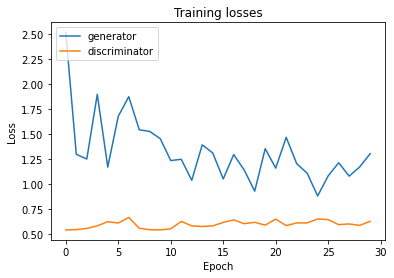

In [13]:
plot_loss_history(history=vanilla_gan_history)

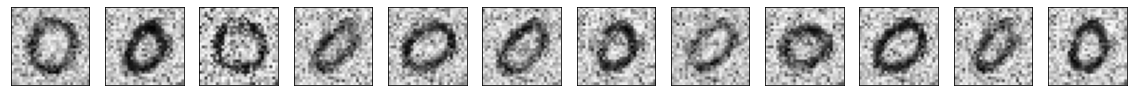

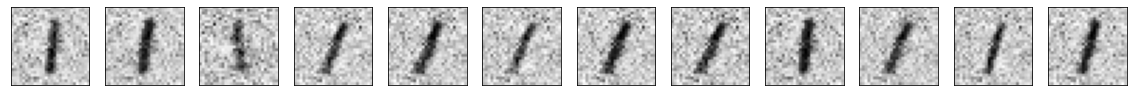

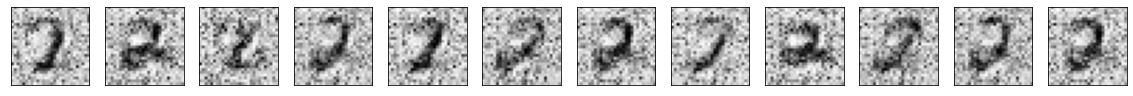

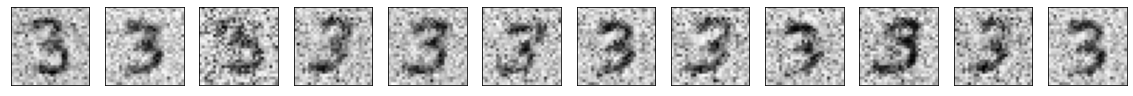

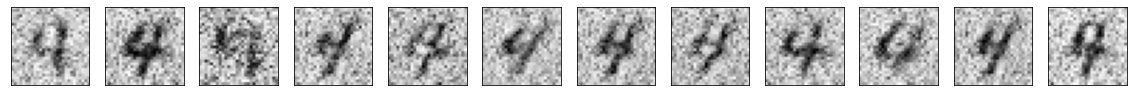

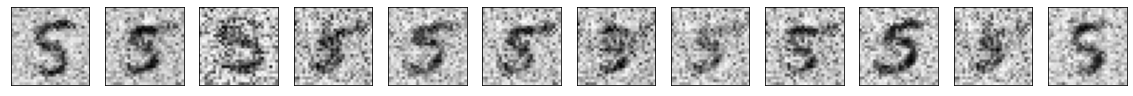

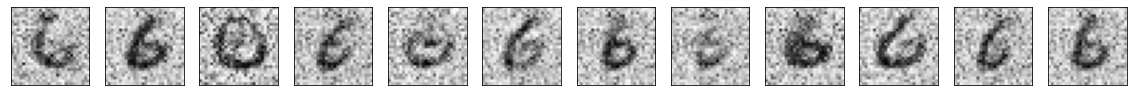

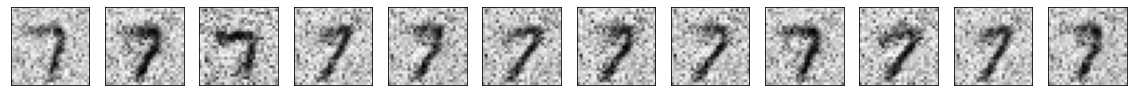

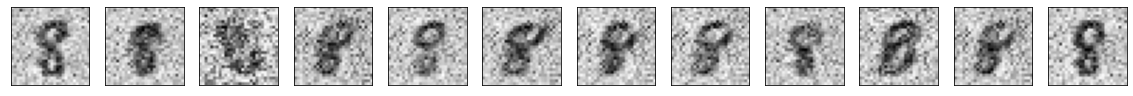

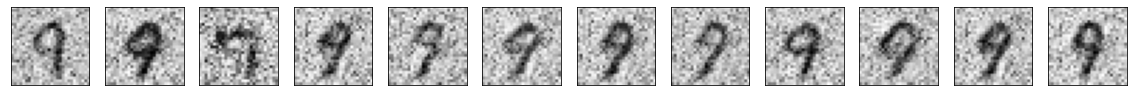

In [14]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=vanilla_gan.generator(
            inputs=[latent_vectors, labels]
        )
    )

## DCGAN

심층 컨볼루션 GAN(DCGAN)은 판별자와 생성자에 대해 각각 `Dense` 레이어 대신 컨볼루션(`Conv2D`) 및 디컨볼루션(`Conv2DTranspose`)을 사용한다.

In [15]:
# 생성기를 만듦
def project_latent_vector(latent_vector, projection_shape):
    """잠재 벡터를 이미지에 투영.

    Args:
        latent_vector: tensor, 모양이 (batch_size, latent_dim)인 라벨들의 2계 텐서.
        projection_shape: 3-tuple, 벡터를 이미지에 투영할 모양.

    Returns:
        latent_image: tensor, 모양이 다음과 같은 4계 텐서
            (
                batch_size,
                projection_shape[0],
                projection_shape[1],
                projection_shape[2]
            ).
    """
    projected_latents = tf.keras.layers.Dense(
        units=projection_shape[0] * projection_shape[1] * projection_shape[2]
    )(inputs=latent_vector)
    projected_latents = tf.keras.layers.LeakyReLU(
        alpha=0.2
    )(inputs=projected_latents)
    latent_image = tf.keras.layers.Reshape(
        target_shape=projection_shape
    )(inputs=projected_latents)

    return latent_image

def create_generator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """레이어의 생성기 블록을 만듦.

    Args:
        inputs: tensor, 모양이 (batch_size, height, width, channels)인 4계 텐서.
        filters: int, 출력 필터/채널 수.
        kernel_size: int/2-tuple of ints, 커널의 높이와 너비.
        strides: int/2-tuple of ints, 슬라이딩 윈도의 각 보폭의 높이와 너비.
        padding: str, 출력의 패딩 유형: same 또는 valid.
        alpha: float, LeakyRelu 활성화의 누출 정도.

    Returns:
        outputs: tensor, 모양이 (batch_size, height * 2, width * 2, filters)인
            4계 이미지 텐서.
    """
    x = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_generator(inputs):
    """표준 DCGAN 생성기 레이어의 출력을 반환.

    Args:
        inputs: tensor, 모양이 (batch_size, y, x, channels)인 4계 텐서.

    Returns:
        outputs: tensor, 모양이 (batch_size, height, width, depth)인 4계 텐서.
    """
    x = create_generator_block(
        inputs=inputs,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_generator_block(
        inputs=x,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding="same", activation="tanh"
    )(inputs=x)

    return outputs

def create_dcgan_generator(latent_dim, num_classes):
    """심층 컨벌루션 조건부 GAN 생성기 모델을 만듦.

    Args:
        latent_dim: int, 잠재 벡터 차원 길이.
        num_classes: int, 이미지 클래스의 수.

    Returns:
        Keras 함수형 모델.
    """
    projection_shape = (7, 7, 256)

    latent_vector = tf.keras.Input(shape=(latent_dim,))
    latent_image = project_latent_vector(latent_vector, projection_shape)
    
    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=projection_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_image, label_image])

    outputs = standard_DCGAN_generator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="dcgan_generator"
    )

dcgan_generator = create_dcgan_generator(
    latent_dim=LATENT_DIM, num_classes=NUM_CLASSES
)
dcgan_generator.summary()

Model: "dcgan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 12544)        6435072     ['input_5[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 50)           500         ['input_6[0][0]']                
                                                                                    

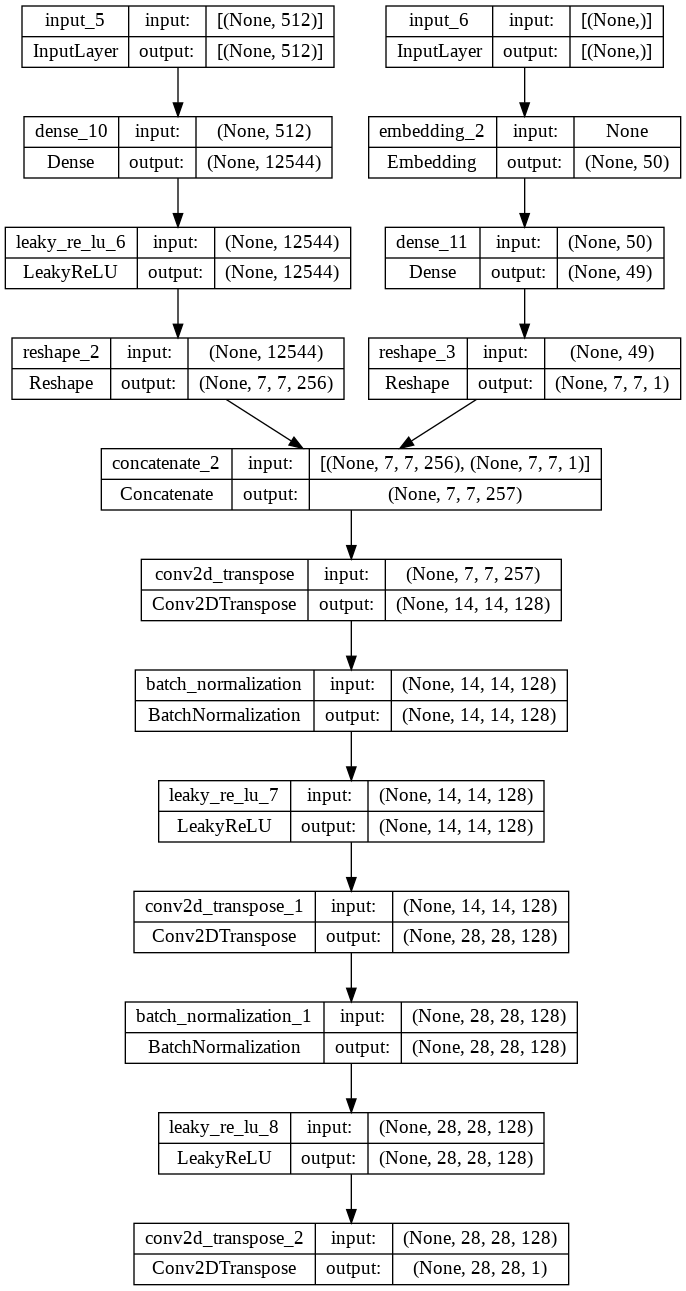

In [16]:
# 생성기 모델을 플롯.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="conditional_dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [17]:
# 판별기를 만듦
def create_discriminator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """레이어의 판별자 블록을 만듦.

    Args:
        inputs: tensor, 모양이 (batch_size, height, width, channels)인 4계
            이미지 텐서.
        filters: int, 출력 필터/채널 수.
        kernel_size: int/2-tuple of ints, 커널의 높이와 너비.
        strides: int/2-tuple of ints, 슬라이딩 윈도의 각 보폭의 높이와 너비.
        padding: str, 출력의 패딩 유형: same 또는 valid.
        alpha: float, LeakyRelu 활성화의 누출 정도.

    Returns:
        outputs: tensor, 모양이 (batch_size, height // 2, width // 2, filters)인
            4계 이미지 텐서.
    """
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_discriminator(inputs):
    """표준 DCGAN 판별자 레이어의 출력을 반환.

    Args:
        inputs: tensor, 모양이 (batch_size, y, x, channels)인 4계 텐서서.

    Returns:
        outputs: tensor, 모양이 (batch_size, 1)인 2계 텐서서.
    """
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding="same"
    )(inputs=inputs)

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=256,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = tf.keras.layers.Flatten()(inputs=x)
    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_dcgan_discriminator(image_shape, num_classes):
    """심층 컨벌루션 조건부 GAN 판별 모델을 만듦듦.

    Args:
        image_shape: tuple, 배치 차원이 없는 이미지의 모양.
        num_classes: int, 이미지 클래스의 수.

    Returns:
        Keras 함수형 모델.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_DCGAN_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="dcgan_discriminator"
    )

dcgan_discriminator = create_dcgan_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50)           500         ['input_8[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 784)          39984       ['embedding_3[0][0]']            
                                                                                                  
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                

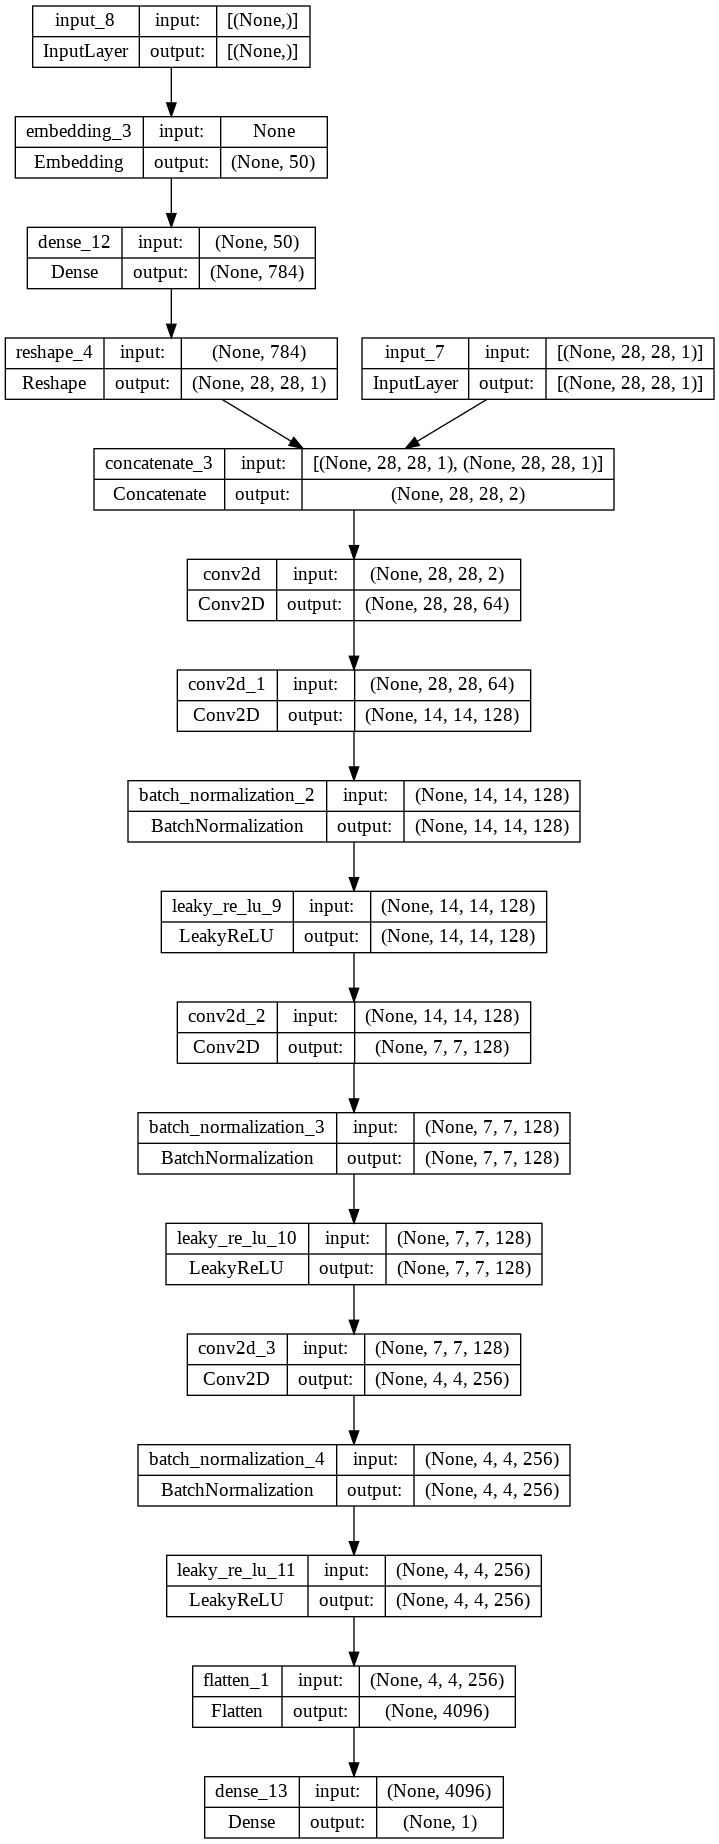

In [18]:
# 생성기 모델을 플롯.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="conditional_dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [19]:
# DCGAN 생성기와 판별자를 사용하여 GAN 인스턴스를 인스턴스화.
dcgan = GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# DCGAN 모델을 훈련.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128), epochs=50)

Epoch 1/50
547/547 [==============================] - 59s 92ms/step - discriminator_loss: 0.5862 - generator_loss: 1.1829
Epoch 2/50
547/547 [==============================] - 50s 92ms/step - discriminator_loss: 0.4769 - generator_loss: 1.7089
Epoch 3/50
547/547 [==============================] - 52s 96ms/step - discriminator_loss: 0.4085 - generator_loss: 2.1629
Epoch 4/50
547/547 [==============================] - 53s 96ms/step - discriminator_loss: 0.4297 - generator_loss: 2.0696
Epoch 5/50
547/547 [==============================] - 53s 96ms/step - discriminator_loss: 0.4345 - generator_loss: 2.0464
Epoch 6/50
547/547 [==============================] - 53s 96ms/step - discriminator_loss: 0.4325 - generator_loss: 2.0470
Epoch 7/50
547/547 [==============================] - 53s 96ms/step - discriminator_loss: 0.4298 - generator_loss: 2.0542
Epoch 8/50
547/547 [==============================] - 53s 97ms/step - discriminator_loss: 0.4235 - generator_loss: 2.0949
Epoch 9/50
547/547 [====

학습된 모델을 사용해 손실 히스토리와 일부 생성된 이미지를 플로팅해 보자.

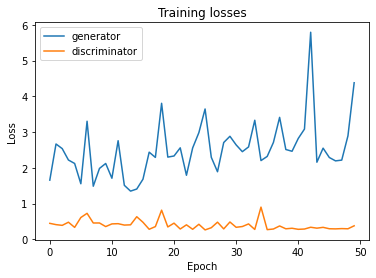

In [20]:
plot_loss_history(history=dcgan_history)

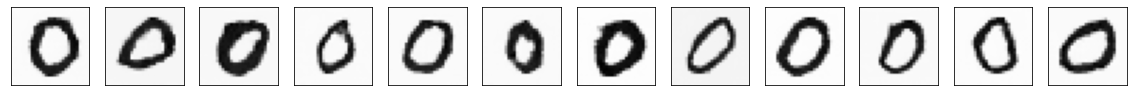

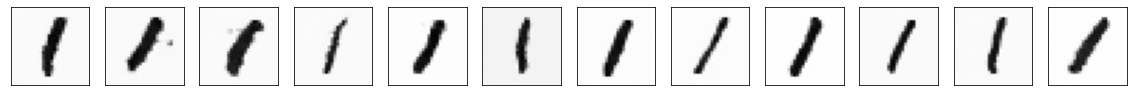

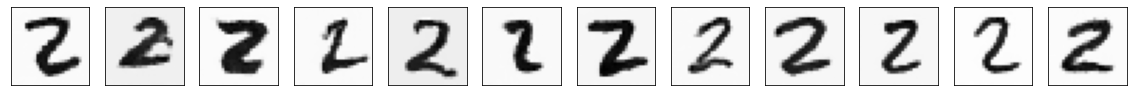

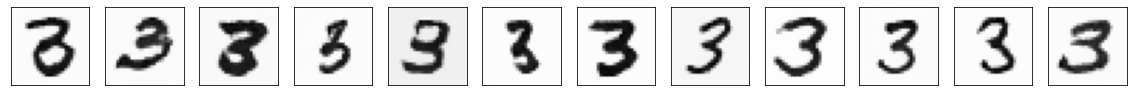

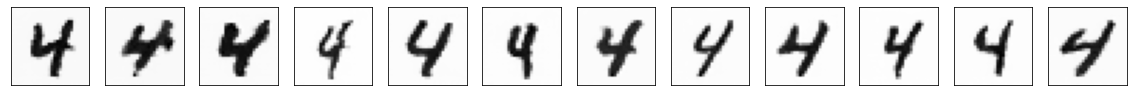

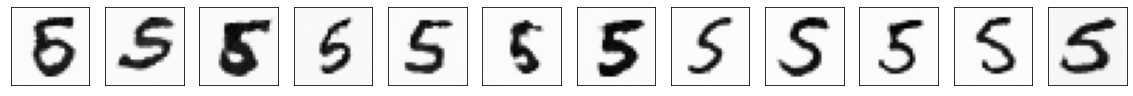

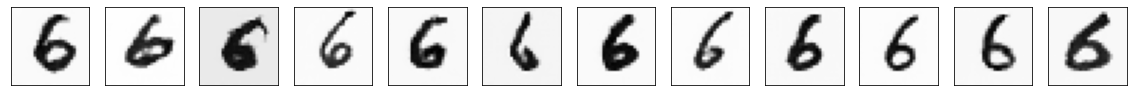

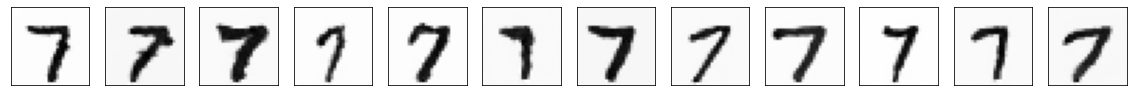

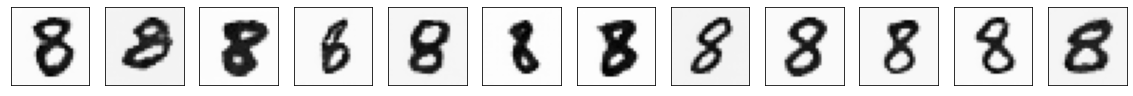

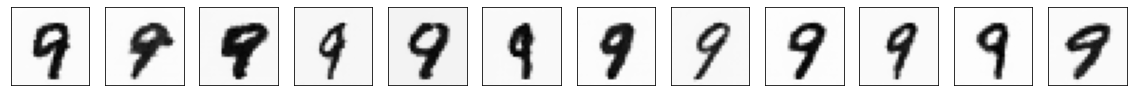

In [21]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=dcgan.generator(
            inputs=[latent_vectors, labels]
        )
    )